In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
#from keras.layers.normalization import BatchNormalization
#from keras.layers.convolutional import Conv2D
#from keras.layers.convolutional import MaxPooling2D
#from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [18]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'D:\Plant_leave_diseases_dataset_with_augmentation'
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:150]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Corn___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn___Common_rust ...
[INFO] Processing Corn___healthy ...
[INFO] Processing Corn___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Background_without_leaves ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)
print(image_size)

2099


In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('abel_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(n_classes)

14


In [7]:
print(label_binarizer.classes_)

['Background_without_leaves' 'Corn___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn___Common_rust' 'Corn___Northern_Leaf_Blight' 'Corn___healthy'
 'Grape___Black_rot' 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Pepper,_bell___Bacterial_spot' 'Pepper,_bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


In [11]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [12]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [13]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [14]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [15]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [16]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [19]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
52/52 [==============================] - 205s 4s/step - loss: 0.6586 - accuracy: 0.3515 - val_loss: 0.9233 - val_accuracy: 0.0905
Epoch 2/25
52/52 [==============================] - 143s 3s/step - loss: 0.2702 - accuracy: 0.5167 - val_loss: 0.6796 - val_accuracy: 0.0667
Epoch 3/25
52/52 [==============================] - 140s 3s/step - loss: 0.1354 - accuracy: 0.6843 - val_loss: 2.8980 - val_accuracy: 0.0786
Epoch 4/25
52/52 [==============================] - 139s 3s/step - loss: 0.1072 - accuracy: 0.7577 - val_loss: 0.7675 - val_accuracy: 0.0786
Epoch 5/25
52/52 [==============================] - 138s 3s/step - loss: 0.0918 - accuracy: 0.8118 - val_loss: 1.2557 - val_accuracy: 0.1190
Epoch 6/25
52/52 [==============================] - 138s 3s/step - loss: 0.0780 - accuracy: 0.8440 - val_loss: 0.6104 - val_accuracy: 0.2310
Epoch 7/25
52/52 [==============================] - 140s 3s/step - loss: 0.0693 - accuracy: 0.8634 - val_loss: 0.8149 - val_accuracy: 0.2405
Epoch 8/25
52

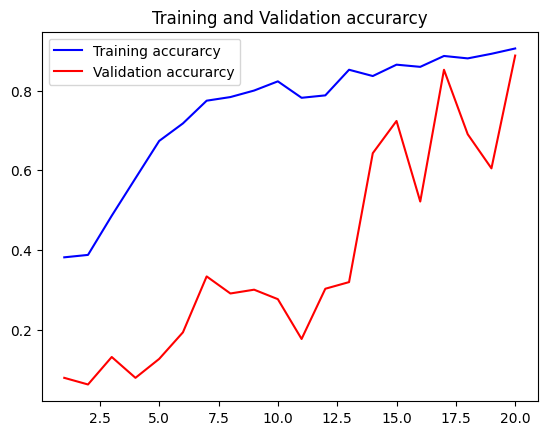

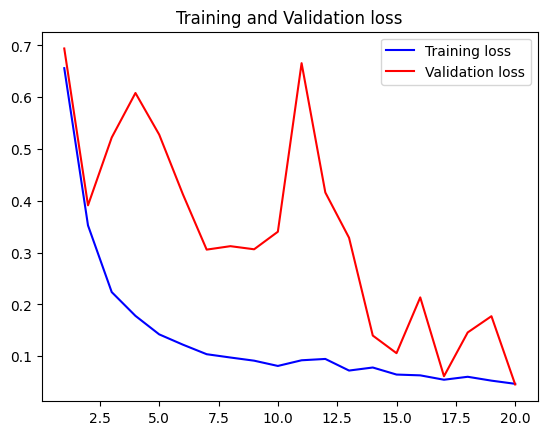

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [22]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
14/14 [==============================] - 15s 498ms/step - loss: 0.0453 - accuracy: 0.8881
Test Accuracy: 88.80952596664429


In [20]:
from tensorflow.keras.preprocessing import image

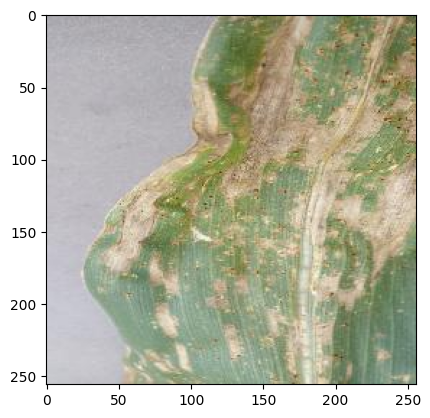

In [24]:
#img_dir="D:\Plant_leave_diseases_dataset_with_augmentation\Grapes\Grape___Esca_(Black_Measles)\image (420).jpg"
#img_dir="D:\Plant_leave_diseases_dataset_with_augmentation\paper_bell\Pepper,_bell___Bacterial_spot\image (340).jpg"
img_dir="D:\Plant_leave_diseases_dataset_with_augmentation\corn\Corn___Cercospora_leaf_spot Gray_leaf_spot\image (239).jpg"

img= image.load_img(img_dir,target_size=(inputShape))
plt.imshow(img)
plt.show()
im=convert_image_to_array(img_dir)
np_image_li=np.array(im,dtype=np.float16)/255.0
npp_image= np.expand_dims(np_image_li,axis=0)

In [25]:
result=model.predict(npp_image)
print(result)

1/1 [==============================] - 0s 70ms/step
[[6.9631627e-11 1.0152140e-02 3.2128713e-01 6.6849697e-01 4.1285944e-06
  3.8381773e-07 1.1577101e-08 2.8606744e-08 9.6526378e-07 1.1000559e-05
  5.0856556e-07 4.2502012e-07 4.6269935e-05 4.6902104e-10]]


In [28]:
itemindex=np.where(result==np.max(result))
print("probability"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability0.66849697
Corn___Northern_Leaf_Blight


In [28]:
print("[INFO] Saving model...")
model.save('fmodel.h5')

[INFO] Saving model...


In [29]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y_test,axis=1)

cm = confusion_matrix(y_test2,pred)
np.set_printoptions(precision=2)
print(cm)
plt.figure()

14/14 [==============================] - 26s 952ms/step
[[14  3  2  4  0  0  0  0  0  0  0  1  0  0]
 [ 0 16  0 13  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 34  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0 34  0  0  0  0  1  0  0  0  1  0]
 [ 0  0  0  0 33  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 16  0  0  3  5  0  0  0  0]
 [ 0  0  0  0  1  1 19  1  0  2  2  0  0  0]
 [ 0  0  0  0  1  0  0 21  3  1  2  1  1  0]
 [ 0  0  0  0  0  0  0  0 26  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 24  6  0  0  0]
 [ 0  0  0  0  0  0  0  0 11  1 22  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  1 28  0  0]
 [ 0  0  2  1  0  0  0  0  9  4  0  2 11  0]
 [ 0  0  2  0  0  0  0  0 16  2  3  0  0  7]]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_binarizer.classes_,rotation=90); ax.yaxis.set_ticklabels(label_binarizer.classes_,rotation=0);